In [1]:
import casadi as ca
import casadi.tools as cat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import networkx as nx
import sys, copy
from scipy.integrate import solve_ivp
import matlab.engine

sys.path.append('.')
sys.path.append('covidOCP/')

from ItalySetup import ItalySetup

from ocp_utils import *

eng = matlab.engine.start_matlab()
eng.cd('geography-paper-master/', nargout=0)
eng.run('single_build.m', nargout=0)

model_size = 20

s = ItalySetup(model_size)

N = 163           # Number of control time interval
T = 163           #52 * 7       # N * 7
n_int_steps = 1

model_days = pd.date_range(s.start_date, s.end_date, freq='1D')
freq = '1D'  # 'W-MON'
model_step = pd.date_range(s.start_date, s.end_date, freq=freq)
mobintime = s.mobility_ts.resample(freq).mean()

N = len(model_step) - 1
T = len(model_days)

N = 30
T = 31

nx = 9

states_list = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
states = states_list

S, E, P, I, A, Q, H, R, V = np.arange(nx)

integ_matlab = np.array(eng.eval('x'))

p_dict, mobfrac, mobmat, betaratiointime, x0 = get_parameters_from_matlab(eng, s, model_size, model_days, freq)

dt = T / N / n_int_steps

obj_params = {
    'scale_ell': 1e4,
    'scale_If': 0,
    'scale_v': 1e-8
}
obj_params = {
    'scale_ell': 1e0,
    'scale_If': 1e2,
    'scale_v': 1e-6
}
betaP0 = p_dict['betaP0']
epsilonA = p_dict['epsilonA']
epsilonI = p_dict['epsilonI']
r = p_dict['r']

p_dict.pop('betaP0')
p_dict.pop('r')
p_dict.pop('epsilonA')
p_dict.pop('epsilonI')
C = mobmat

Loaded Italy Setup with 20 nodes.


### implement the vaccintion as we did for mobility, computer outside the ODE. make like easier.

```
        x_ = ca.veccat(*states[...])
        u_ = ca.veccat(*controls[...])
        R_ = states['R']
        SpR = pop_nodeSX - states['I'] - states['V']
        x_[1] -= controls['v']*R_/(SpR+1e-10)
        x_[3] += controls['v']*SpR/(SpR+1e-10)
        ell = 0.
        
        for k in range(n_int_steps):
          x, ell = rk4_step(x_,u_,covar, params, pop_nodeSX)
          ell += ell_
            
```
JIT compilation
```
dae = {'x':states, 'p':ca.veccat(controls,covar,params,pop_nodeSX), 'ode':rhs, 'quad':scale_ell*rhs_ell + scale_v*v*v}
int_type = 'rk'
# int_type = 'collocation'

opts = {'tf':T/N, 'number_of_finite_elements':n_int_steps}
opts["jit"] = True
opts["compiler"] = "shell"
opts["simplify"] = True
opts["expand"] = True

F = ca.integrator('F', int_type, dae, opts)
```


In [2]:
def rhs_py(t, x, u, cov, p, mob, pop_node):
    S, E, P, I, A, Q, H, R, V = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    deltaE, deltaP,sigma,eta,gammaI,gammaA,gammaQ,gammaH,alphaI,alphaH, zeta,  gammaV = \
    p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11]
   
    v = u[0]
    foi = mob
    rhs = [None] * nx
    vaccrate = v / (S + E + P + A + Q + H + R+1)  # NOT I NOT H ?
    vaccrate = v / ca.sqrt((S+E+P+A+Q+H+R)**2+10)   # 10 (1e7 ?1e3 ?)is to tune depending on scale, approx abs. value (brings quantities non negative by vaccinating)
    vaccrate = 0
    rhs[0] = -(foi + vaccrate) * S + gammaV * V                 # S
    rhs[1] = foi * S - deltaE * E;                              # E 
    rhs[2] = deltaE * E - deltaP * P;                           # P
    rhs[3] = sigma * deltaP * P - (eta + gammaI + alphaI) * I;  # I
    rhs[4] = (1 - sigma) * deltaP * P - gammaA * A;             # A
    rhs[5] = zeta * eta * I - gammaQ * Q;                       # Q
    rhs[6] = (1 - zeta) * eta * I - (gammaH + alphaH) * H;      # H
    rhs[7] = gammaI * I + gammaA * A + gammaH * H + gammaQ * Q;  # R
    rhs[8] = vaccrate * S - gammaV * V                           # V
    rhs_ell = [None] * 3
    rhs_ell[0] = gammaH * H;  # recovered from the hospital
    rhs_ell[1] = alphaH * H;  # total death
    rhs_ell[2] = (1 - zeta) * eta * I;  # cumulative hospitalized cases

    return rhs, rhs_ell

In [3]:
setup = s
model_params = copy.copy(p_dict)
ind2name = setup.ind2name
#ind_to_plot = setup.ind_to_plot
pop_node = setup.pop_node

M = setup.nnodes
mobility = setup.mobility

print(f'Building OCP with {M} nodes')

c = setup.mobility

scale_ell = obj_params['scale_ell']
scale_If = obj_params['scale_If']
scale_v = obj_params['scale_v']
pnum = params_to_vector(model_params)

pnum.append(scale_ell)
pnum.append(scale_If)
pnum.append(scale_v)

# ---- decision variables ---------
states = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
states = cat.struct_symSX(states)
[S, E, P, I, A, Q, H, R, V] = states[...]

controls = cat.struct_symSX(['v', 'mob'])
[v, mob] = controls[...]

covar = cat.struct_symSX(['J'])
[J] = covar[...]

params = cat.struct_symSX(list(model_params.keys()) + ['scale_ell', 'scale_If', 'scale_v'])
[deltaE, deltaP, sigma, eta, gammaI, gammaA, gammaQ, gammaH, alphaI, alphaH, zeta, gammaV,
 scale_ell, scale_If, scale_v] = params[...]

pop_nodeSX = ca.SX.sym('pop_node')


# The rhs is at time zero, the time is also no used in the equation so that exoplain
rhs, rhs_ell = rhs_py(0, states.cat, controls.cat, covar.cat, params.cat, mob, pop_nodeSX)
rhs = ca.veccat(*rhs)
rhs_ell = ca.veccat(*rhs_ell)  # mod

Building OCP with 20 nodes


In [4]:
frhs = ca.Function('frhs', [states, controls, covar, params, pop_nodeSX],
                           [rhs, rhs_ell[1]])#scale_ell * rhs_ell[1] + scale_v * v * v])# mod ICI juste ell[1]

In [5]:
frhs

Function(frhs:(i0[9],i1[2],i2,i3[15],i4)->(o0[9],o1) SXFunction)

In [6]:
dt = T / N / n_int_steps  # length of an integration interval
# ---- dynamic constraints --------
k1, k1ell = frhs(states, controls, covar, params, pop_nodeSX)
k2, k2ell = frhs(states + dt / 2 * k1, controls, covar, params, pop_nodeSX)
k3, k3ell = frhs(states + dt / 2 * k2, controls, covar, params, pop_nodeSX)
k4, k4ell = frhs(states + dt * k3, controls, covar, params, pop_nodeSX)
x_next = states + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
ell_next = dt / 6 * (
        k1ell + 2 * k2ell + 2 * k3ell + k4ell)  # No need for because we sum it week by week few lines below.

rk4_step = ca.Function('rk4_step', [states, controls, covar, params, pop_nodeSX], [x_next, ell_next])

In [7]:
dt = T / N / n_int_steps  # length of an integration interval
a, b = frhs(states, controls, covar, params, pop_nodeSX)
x_next = states + dt*a
ell_next = dt*b
rk4_step = ca.Function('rk4_step', [states, controls, covar, params, pop_nodeSX], [x_next, ell_next])

In [8]:
x_ = ca.veccat(*states[...])
u_ = ca.veccat(*controls[...])
ell = 0.
VacPpl = states['S'] + states['E'] + states['P'] + states['A'] + states['R']
vaccrate = controls['v']/(VacPpl+1e-10)
x_[0] -= vaccrate * states['S']
x_[8] += vaccrate * states['S']
for k in range(n_int_steps):
    x_, ell_ = rk4_step(x_, u_,covar, params, pop_nodeSX)
    ell += ell_

In [9]:
rk4_int = ca.Function('rk4_int', [states, ca.veccat(controls, covar, params, pop_nodeSX)], [x_, ell],
                      ['x0', 'p'], ['xf', 'qf'])

# BUG TODO Isn't this a double multiplication by the scale parameter since ell is already multiplied ?
ell = ca.Function('ell', [states, controls, covar, params, pop_nodeSX],
                  [scale_ell * ell + scale_v * v * v, scale_ell * ell,
                   scale_v * v * v])  # Very dependent on regularization factor
#ell = ca.Function('ell', [states, controls, covar, params, pop_nodeSX],
#                  [ell, scale_ell * ell,
#                   scale_v * v * v])  # Very dependent on regularization factor

In [10]:
Vars = cat.struct_symMX([
    (
        cat.entry("x", struct=states, repeat=[M, N + 1]),
        cat.entry("u", struct=controls, repeat=[M, N]),
    ),
])

Params = cat.struct_symMX([
    (
        cat.entry("cov", struct=covar, repeat=[M, N]), 
        cat.entry("p", struct=params),
    ),
])

In [11]:
lbx = Vars(-np.inf)
ubx = Vars(np.inf)

f = 0
vaccines = 0
cases = 0
reg = 0
cdot_T = 0
dyn = [None] * N
spatial = [None] * N

mob_prun = 0.0001
mob_prun = .005
mob_prun = .01 # not tested

for k in range(N):
    mobK = mobintime.to_numpy().T[:,k]
    betaR = betaratiointime.to_numpy().T[:,k]
    C = r*mobfrac.flatten()*mobK*mobmat
    np.fill_diagonal(C,1-C.sum(axis=1)+ C.diagonal())
    
    dyn[k] = []
    spatial[k] = []
    Sk, Ek, Pk, Rk, Ak, Ik = ca.veccat(*Vars['x', :, k, 'S']), ca.veccat(*Vars['x', :, k, 'E']), \
                             ca.veccat(*Vars['x', :, k, 'P']), ca.veccat(*Vars['x', :, k, 'R']), \
                             ca.veccat(*Vars['x', :, k, 'A']), ca.veccat(*Vars['x', :, k, 'I'])

    if k == 0 or k == N-1:
        print(f'pruning {C[C<mob_prun].size} non-diagonal mobility elements of {C.size-M}.')  
    C[C<mob_prun] = 0 # Prune elements
        
    mob_ik=C@((C.T@(betaP0*betaR*(Pk+epsilonA*Ak))+epsilonI*betaP0*betaR*Ik)/ \
             (C.T@(Sk+Ek+Pk+Rk+Ak)+Ik))
    print(f'{k}:', end='')
    for i in range(M):
        [X_, ell_ik] = rk4_int(Vars['x', i, k],
                               ca.veccat(Vars['u', i, k], Params['cov', i, k], Params['p'], pop_node[i]))

        dyn[k].append(Vars['x', i, k + 1] - X_)
        ell_ik_, cases_ik, reg_ik = ell(Vars['x', i, k], Vars['u', i, k], Params['cov', i, k], Params['p'], pop_node[i])
        f += ell_ik_ #MOD: before  ell_ik_
        cases += cases_ik
        reg += reg_ik
        
        spatial[k].append(Vars['u', i, k, 'mob'] - mob_ik[i]) # spatial, vaccines and dyn are put in g(x), with constraints that spatial and dyn are equal to zero
        # thus imposing the dynamics and coupling.
        vaccines += Vars[ 'u', i, k, 'v'] * T / N  # Number of vaccine spent = num of vaccine rate * 7 (number of days)

f /= T  # Average over interval for cost ^ but not terminal cost 

pruning 367 non-diagonal mobility elements of 380.
0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15:16:17:18:19:20:21:22:23:24:25:26:27:28:pruning 367 non-diagonal mobility elements of 380.
29:

In [12]:
C.shape

(20, 20)

In [13]:
print('Writing constraints, ...', end='')
g = cat.struct_MX([
    cat.entry("dyn", expr=dyn),
    cat.entry("spatial", expr=spatial),
    cat.entry("vaccines", expr=vaccines),
])

costTerms = ca.Function('costTerms', [Vars, Params], [cases, reg])


# This initialize
lbg = g(0)
ubg = g(0)


ubg['vaccines'] = 2000. * M
lbg['vaccines'] = -np.inf

optimize = 1
lbx['u', :, :, 'v'] = 0.
ubx['u', :, :, 'v'] = 1000 * optimize  # = 0 if we don't want to optimize
# ubx['u',:,:,'v'] = 0
#ubx['u', :, :1, 'v'] = 0.


# Set initial conditions as constraints
for cp, name in enumerate(states.keys()):
    for i in range(M):
        lbx['x', i, 0, name] = ubx['x', i, 0, name] = x0[i*nx+cp]

print('DONE')
print('Building NLP function...', end='')

# NLOP arguments:
# 'x' : variable names to optimize: here states and control
# 'p' : params that can be change after
# 'f' is the objective function of 'x', that we ought to minize
# 'g' is a function that goes lbg < g(x,p) < ubg. If you want equality constraint then ubg = lbg = the number yoiu want it to be.
nlp = {'x': Vars, 'p': Params, 'f': f, 'g': g}
nlpFun = ca.Function('nlpFun', [Vars, Params], [f, g])
print('DONE')
print('Building Jacobian function...', end='')
nlpJac = nlpFun.factory('nlpJac', ['i0', 'i1'], ['jac:o1:i0'])

print('DONE')
print('Building Solver...', end='')

options = {}
options['ipopt'] = {}
options['ipopt']["linear_solver"] = "ma57"
options['ipopt']["linear_solver"] = "ma86"
# options['ipopt']["linear_solver"] = "ma86"
# options['ipopt']["linear_solver"] = "ma97"
# options['ipopt']['bound_frac'] = 1e-4
# options['ipopt']['bound_push'] = 1e-4
# options['ipopt']['slack_bound_frac'] = 1e-4
# options['ipopt']['slack_bound_push'] = 1e-6
# options['ipopt']['hessian_constant'] = 'yes'
# options['ipopt']["tol"] = 1e-8

solver = ca.nlpsol('solver', "ipopt", nlp, options)

# options = {}
# options['ls_step_factor'] = 0.5
# options['pr_tol'] = 1e-8
# options['du_tol'] = 1e-8
# options['qp_solver'] = 'nlpsol'
# options['qp_solver_options']  = {'nlpsol':'ipopt','nlpsol_options':{'print_time':False,'ipopt.print_level':0,'ipopt.hessian_constant':'yes','ipopt.linear_solver':'ma97','ipopt.tol':1e-16}}
# # options['regularization'] = 'regularize_reduced'
# options['regularization'] = 'regularize_reduced_diag'
# options['regularization_tol'] = 1e-10
# options['linesearch'] = 'filter'
# options["iteration_callback"] = plotIterates
# self.solver = SQPmethod(nlp,options)

print('DONE')

Writing constraints, ...DONE
Building NLP function...DONE
Building Jacobian function...DONE
Building Solver...DONE


In [14]:
integ_matlab = np.array(eng.eval('x'))

init = Vars(0)
for i, name in enumerate(states.keys()):
    for k in range(N + 1):
        # init['x',:,k,name] = sol0.y[i,k]
        for nd in range(M):
            init['x', nd, k, name] = integ_matlab.T[nd+107*i, k].T # p['x0']  # self.ic[name][i]

init['u'] = 0.

arg = {}
arg['lbg'] = lbg
arg['ubg'] = ubg

arg['lbx'] = lbx
arg['ubx'] = ubx
arg['x0'] = init
arg['p'] = Params()
# for i in range(M):
#    for k in range(N):
#        arg['p']['cov',i,k] = rainfall_norm[i,k]**params(pnum)['r']
# arg['p']['cov',i,k] = np.random.random()**params(pnum)['r']

arg['p']['p'] = pnum

In [15]:
#pnum.append(scale_ell)
#pnum.append(scale_If)
#pnum.append(scale_v)
pnum[-3] = 1e8
pnum[-2] = 0
pnum[-1] = 1e-30
arg['p']['p'] = pnum

In [16]:
arg['p']['p']

DM([0.217391, 0.5, 0.25, 0.25, 0.0714286, 0.142857, 0.0714286, 0.0714286, 0.0333333, 0.0333333, 0.45, 0.025, 1e+08, 0, 1e-30])

In [17]:
sol = solver(**arg)
opt = Vars(sol['x'])
lam_g = g(sol['lam_g'])
lam_x = Vars(sol['lam_x'])
[fnum,gnum]=nlpFun(opt,arg['p'])
Jgnum=nlpJac(opt, arg['p'])
gnum = g(gnum)
print(f"""
Vaccines stockpile: 
    {float(arg['ubg']['vaccines']):010f} total.
    {float(g(gnum)['vaccines']):010f} spent.
    {float((arg['ubg']['vaccines']  - g(gnum)['vaccines'])):010f} left.""")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    97160
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:   212030

Total number of variables............................:     6600
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constrai

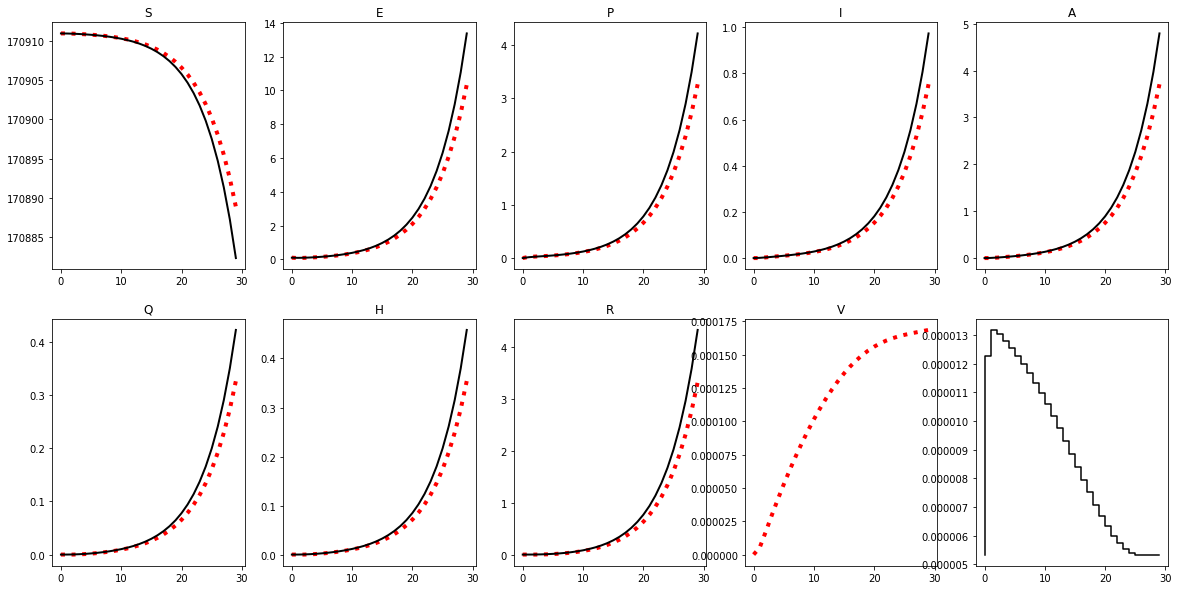

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,5, figsize = (20,10))
node = 1
til =  30#-1

for i, st in enumerate(states_list):
    axes.flat[i].plot(np.array(ca.veccat(*opt['x',node,:til,st])), 
                  linestyle=':', lw = 4, color='r')
    if st != 'V':
        axes.flat[i].plot(np.array(integ_matlab.T[node+107*i,:til].T), 
                  linestyle='-', lw = 2, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(np.array(ca.veccat(ca.veccat(*opt['u',node,:til,'v']))),#,opt['u',node,-1,'v'])),
                  'k',label=r"$\nu(t)$");

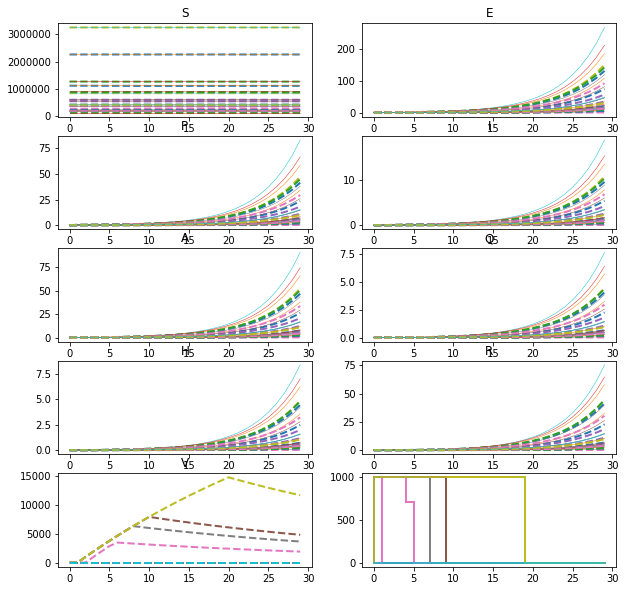

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,2, figsize = (10,10))
node = 1
til = 30 # -1

for i, st in enumerate(states_list):
    for k in range(M):
        axes.flat[i].plot(np.array(ca.veccat(*opt['x',k,:til,st])), 
                   lw = 2, ls = '--')
        if st != 'V':
            axes.flat[i].plot(np.array(integ_matlab.T[k+107*i,:til].T), 
                   lw = .5)
        axes.flat[i].set_title(st);
        axes.flat[-1].step(np.arange(til),
            np.array(ca.veccat(ca.veccat(*opt['u',k,:til,'v']))))

In [20]:
len(np.array(ca.veccat(ca.veccat(*opt['u',k,:til,'v']))))

30

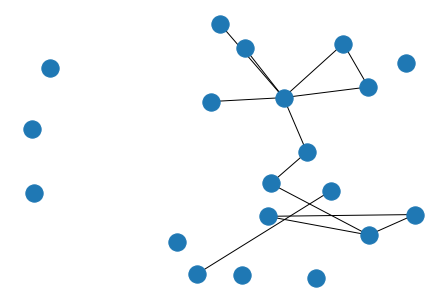

In [21]:
import networkx
grph = networkx.from_numpy_matrix(C)
networkx.draw(grph, )

In [22]:
a = mob_ik

In [23]:
a[1] = 0

In [27]:
mob_ik[0]

MX(@1=vertsplit(V), @2=vertsplit(@1{29}), @3=vertsplit(@1{90}), @4=vertsplit(@1{151}), @5=vertsplit(@1{212}), @6=vertsplit(@1{273}), @7=vertsplit(@1{334}), @8=vertsplit(@1{395}), @9=vertsplit(@1{456}), @10=vertsplit(@1{517}), @11=vertsplit(@1{578}), @12=vertsplit(@1{639}), @13=vertsplit(@1{700}), @14=vertsplit(@1{761}), @15=vertsplit(@1{822}), @16=vertsplit(@1{883}), @17=vertsplit(@1{944}), @18=vertsplit(@1{1005}), @19=vertsplit(@1{1066}), @20=vertsplit(@1{1127}), @21=vertsplit(@1{1188}), @22=vertcat(@2{2}, @3{2}, @4{2}, @5{2}, @6{2}, @7{2}, @8{2}, @9{2}, @10{2}, @11{2}, @12{2}, @13{2}, @14{2}, @15{2}, @16{2}, @17{2}, @18{2}, @19{2}, @20{2}, @21{2}), @23=vertcat(@2{4}, @3{4}, @4{4}, @5{4}, @6{4}, @7{4}, @8{4}, @9{4}, @10{4}, @11{4}, @12{4}, @13{4}, @14{4}, @15{4}, @16{4}, @17{4}, @18{4}, @19{4}, @20{4}, @21{4}), @24=vertcat(@2{3}, @3{3}, @4{3}, @5{3}, @6{3}, @7{3}, @8{3}, @9{3}, @10{3}, @11{3}, @12{3}, @13{3}, @14{3}, @15{3}, @16{3}, @17{3}, @18{3}, @19{3}, @20{3}, @21{3}), (mac(
[[0.9

In [25]:
from scipy import sparse

In [26]:
C = sparse.csr_matrix(C)

C@((C.T@(betaP0*betaR*(Pk+epsilonA*Ak))+epsilonI*betaP0*betaR*Ik)/ \
             (C.T@(Sk+Ek+Pk+Rk+Ak)+Ik))

Exception: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.

In [ ]:
sum(C[i, m] * (
            (sum(C[n, m] * (betaP0*betaR[n]*(Pk[n]+epsilonA*Ak[n])) for n in range(M)) + epsilonI*betaP0*betaR[m]*Ik[m]) /
            (sum(C[l, m]*(Sk[l]+Ek[l]+Pk[l]+Rk[l]+Ak[l]) for l in range(M)) + Ik[m]))
             for m in range(M))